# Analysis of temporal statistics using the occupation probability

This notebook reproduces the figures in the introduction of:<br>
**Measuring and modeling the occupation probability to characterize the temporal statistics of seismic sequences**,<br>
submitted to *Geophysical Journal International*, by Eric Beaucé

Download the data required by this notebook at:<br>
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15675634.svg)](https://doi.org/10.5281/zenodo.15675634)

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import eqtempclust

import colorcet as cc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import string

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from obspy import UTCDateTime as udt
from scipy.interpolate import interp1d


# --------------------------------------
#        comment this section out if you don't want to use seaborn
import seaborn as sns
sns.set_theme(font_scale=1.3)
sns.set_style("ticks")
sns.set_palette("colorblind")
# --------------------------------------

plt.rcParams["savefig.dpi"] = 200
plt.rcParams["svg.fonttype"] = "none"


## Load data

In [2]:
PATH_DATA = "./data/"
DATASET_FILENAME = "database_intro_GJI_Beauce_2025.h5"

In [3]:
event_timings = {}
with h5.File(os.path.join(PATH_DATA, DATASET_FILENAME), mode="r") as fdb:
    for key in fdb:
        event_timings[key] = fdb[key][()]
        time_span_sec = np.max(event_timings[key]) - np.min(event_timings[key])
        # print(f"{key}: {time_span_sec / (3600.  * 24.):.2f} days")
dataset_names = list(event_timings)
print(dataset_names)

['dora_maira', 'naf', 'or3b', 'or5', 'pawnee_after', 'pawnee_before', 'socal']


In [4]:
beautiful_names = {}
beautiful_names["naf"] = "NAF (Sapanca Lake)"
beautiful_names["socal"] = "Southern California"
beautiful_names["dora_maira"] = "Alps (Dora Maira)"
beautiful_names["or3b"] = "Experiment 2 (or3b)"
beautiful_names["or5"] = "Experiment 1 (or5)"
beautiful_names["pawnee_before"] = "Oklahoma before M5.8"
beautiful_names["pawnee_after"] = "Oklahoma after M5.8"

## Analysis

In [5]:
NORMALIZED_TAU_MIN = 1.e-3
NORMALIZED_TAU_MAX = 1.e5
BASE_LOG = 2.0
RETURN_NORMALIZED_TIMES = True
NUM_RESAMPLINGS = 50
FIX_BETA = False

In [6]:
shortest_resolved_time = {}
shortest_resolved_time["naf"] = 5. # 5 seconds
shortest_resolved_time["dora_maira"] = 30. # 5 seconds
shortest_resolved_time["or3b"] = 1.e-4 # 0.1 microseconds
shortest_resolved_time["or5"] = 1.e-4 # 0.1 microseconds
shortest_resolved_time["socal"] = 60.
shortest_resolved_time["pawnee_before"] = 5.
shortest_resolved_time["pawnee_after"] = 5.

In [7]:
occupation = {}
for dataset in shortest_resolved_time:
    num_events = len(event_timings[dataset])
    time_span = np.max(event_timings[dataset]) - np.min(event_timings[dataset])
    avg_iet = time_span / (num_events - 1)
    avg_iet_days = avg_iet / (3600. * 24.)
    avg_iet_mins = avg_iet / (60.)
    print(f"{dataset}: {num_events} earthquakes over {time_span / (3600. * 24.):.2f} days, avg IET = {avg_iet_days:.2f} days ({avg_iet_mins:.2f} minutes)")
    # ------------------------------------------
    occupation[dataset] = eqtempclust.run_occupation_analysis2(
        event_timings[dataset],
        NORMALIZED_TAU_MIN,
        NORMALIZED_TAU_MAX,
        nbins_wt=15,
        shortest_resolved_time=shortest_resolved_time[dataset],
        fix_beta=FIX_BETA,
        base_log=BASE_LOG,
        num_resamplings=NUM_RESAMPLINGS,
        use_valid_only=2,
    )

naf: 268 earthquakes over 448.98 days, avg IET = 1.68 days (2421.48 minutes)
dora_maira: 1285 earthquakes over 328.09 days, avg IET = 0.26 days (367.95 minutes)
or3b: 4437 earthquakes over 0.99 days, avg IET = 0.00 days (0.32 minutes)
or5: 200 earthquakes over 1.88 days, avg IET = 0.01 days (13.61 minutes)
socal: 255 earthquakes over 1458.16 days, avg IET = 5.74 days (8266.71 minutes)
pawnee_before: 3409 earthquakes over 1720.67 days, avg IET = 0.50 days (727.05 minutes)
pawnee_after: 1001 earthquakes over 118.42 days, avg IET = 0.12 days (170.53 minutes)


## Print each model's AIC 

In [8]:
for dataset in occupation:
    aic_gamma = occupation[dataset]["aic_gamma"]
    aic_fractal = occupation[dataset]["aic_fractal"]
    # probability that fractal model minimizes the information loss instead of the gamma model
    p = np.exp((aic_gamma - aic_fractal) / 2.0)
    print(
        f"Fractal model is {p:.2e} more likely than the gamma model for {dataset} (aic: {aic_gamma:.2f} vs {aic_fractal:.2f})"
    )

Fractal model is 4.46e+10 more likely than the gamma model for naf (aic: -109.98 vs -159.02)
Fractal model is 1.48e+16 more likely than the gamma model for dora_maira (aic: -51.98 vs -126.45)
Fractal model is 6.70e-01 more likely than the gamma model for or3b (aic: -160.46 vs -159.65)
Fractal model is 8.44e+09 more likely than the gamma model for or5 (aic: -84.93 vs -130.64)
Fractal model is 8.90e-10 more likely than the gamma model for socal (aic: -209.77 vs -168.09)
Fractal model is 1.81e+11 more likely than the gamma model for pawnee_before (aic: -103.45 vs -155.29)
Fractal model is 8.49e-02 more likely than the gamma model for pawnee_after (aic: -170.36 vs -165.43)


## Figure 1 (intro)

Text(0.5, 0.5, '$\\propto \\tau^{1 - D_\\tau}$')

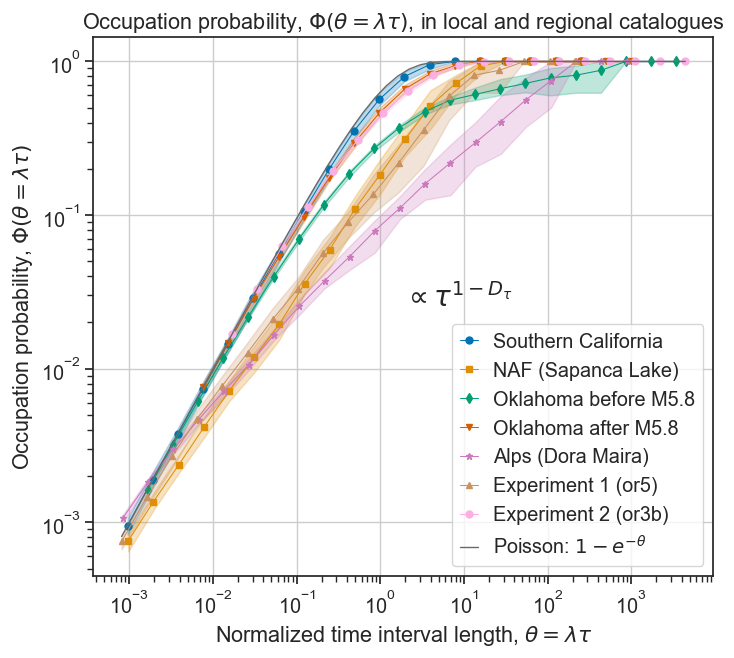

In [9]:
markers = ["o", "s", "d", "v", "*", "^"]
plotting_order = [
    "socal", "naf", "pawnee_before", "pawnee_after", "dora_maira", "or5", "or3b", 
]

fig, ax = plt.subplots(num="fig1_intro", figsize=(8, 7))

tau_min, tau_max = 1., 0.
for i, name in enumerate(plotting_order):
    line, = ax.plot(
        occupation[name]["tau"], occupation[name]["Phi"], ls="-", lw=0.75, markersize=5,
        marker=markers[i%len(markers)], label=beautiful_names[name]
    )
    ax.fill_between(
        occupation[name]["tau"],
        occupation[name]["Phi_lower"],
        occupation[name]["Phi_upper"],
        color=line.get_color(),
        alpha=0.25,
    )
    if occupation[name]["tau"].min() < tau_min:
        tau_min = occupation[name]["tau"].min()
    if occupation[name]["tau"].max() > tau_max:
        tau_max = occupation[name]["tau"].max()

tau_Pois = np.logspace(np.log10(tau_min), np.log10(tau_max), 50)
ax.plot(tau_Pois, 1. - np.exp(-tau_Pois), color="dimgrey", lw=1, label=r"Poisson: $1 - e^{-\theta}$")
ax.loglog()
ax.grid()
ax.set_xlabel(r"Normalized time interval length, $\theta = \lambda \tau$")
ax.set_ylabel(r"Occupation probability, $\Phi(\theta = \lambda \tau)$")
ax.legend(loc="lower right", handlelength=0.9)
ax.set_title(r"Occupation probability, $\Phi(\theta = \lambda \tau)$, in local and regional catalogues")

ax.text(0.5, 0.5, r"$\propto \tau^{1 - D_\tau}$", fontsize=20, transform=ax.transAxes)

In [10]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

## Bonus Figure 1 (detailed results with one catalog)

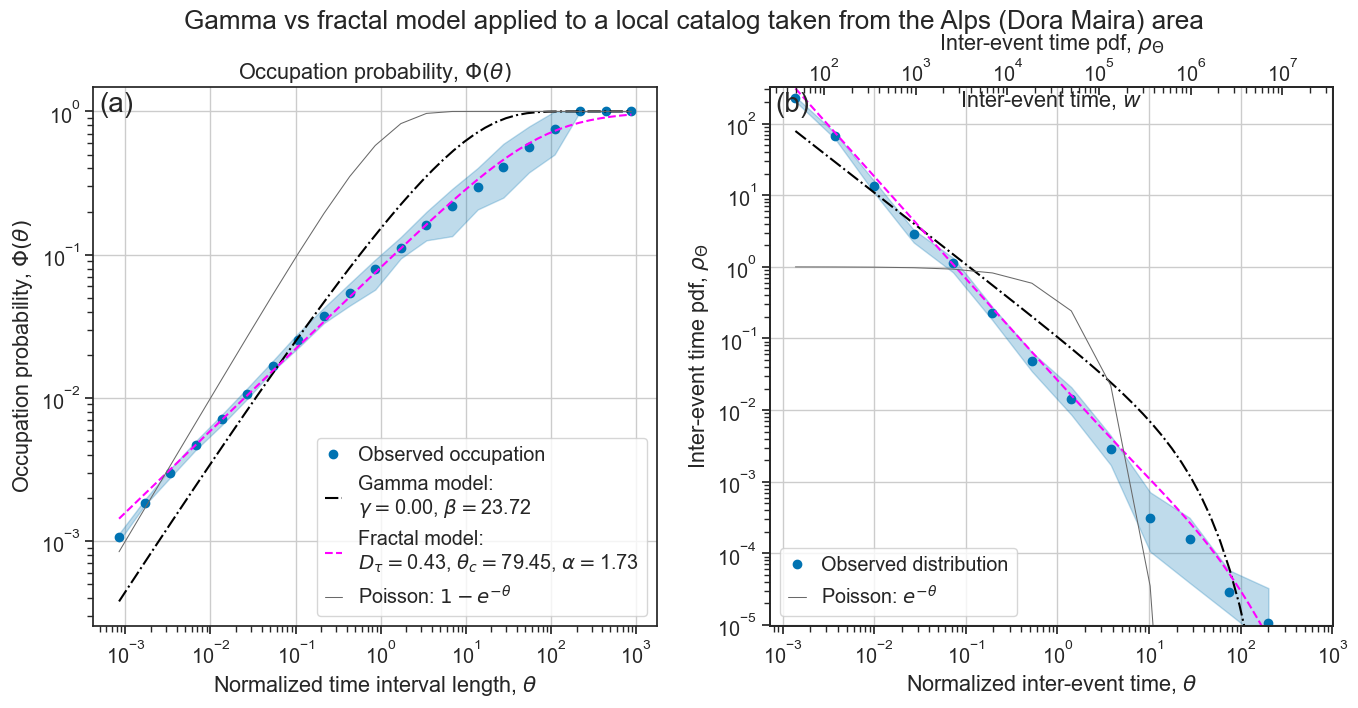

In [11]:
fig = eqtempclust.plot_gamma_vs_fractal(
    occupation["dora_maira"],
    num_points_fit=50,
    figtitle=f"Gamma vs fractal model applied to a local catalog taken from the {beautiful_names['dora_maira']} area",
    plot_physical_wt=True,
)

## Figure 2 (all results)

### Part 1 (fractal model)

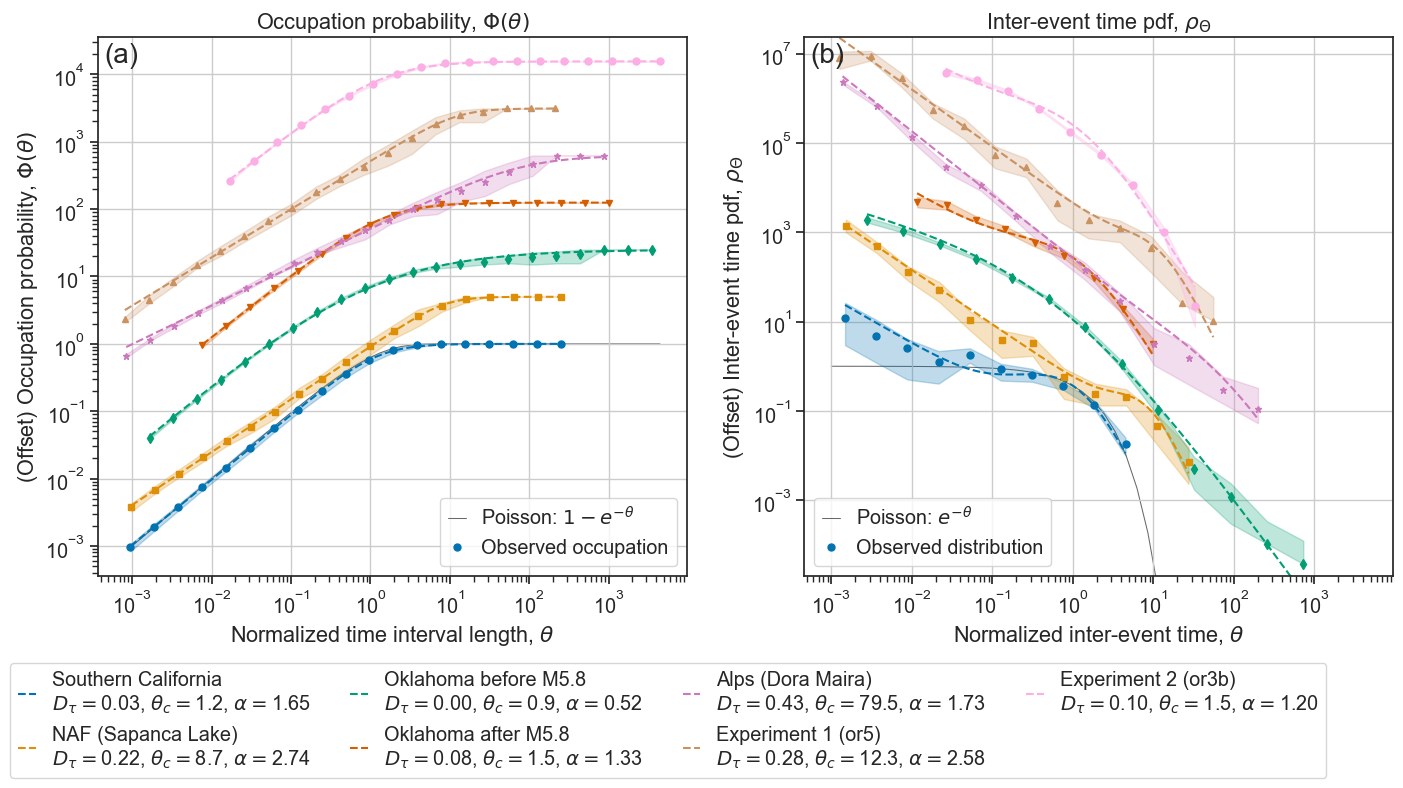

In [12]:
markers = ["o", "s", "d", "v", "*", "^"]
base_offset_occ = 5.0

fig, axes = plt.subplots(num="all_results_fractal", ncols=2, figsize=(14, 7))
plt.subplots_adjust(left=0.07, right=0.995)

time_max = max([occupation[ds]["tau"].max()] for ds in dataset_names)
wt_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
tau_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
axes[0].plot(
    tau_fit,
    1.0 - np.exp(-tau_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $1 - e^{-\theta}$",
)
axes[1].plot(
    wt_fit,
    np.exp(-wt_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $e^{-\theta}$",
)

fit_labels = []
fit_plots = []

for i, name in enumerate(plotting_order):
    wt_pdf = occupation[name]["wt_pdf"]
    wt_pdf_lower = occupation[name]["wt_pdf_lower"]
    wt_pdf_upper = occupation[name]["wt_pdf_upper"]
    wt_bins = occupation[name]["wt_bins"]
    tau = occupation[name]["tau"]
    Phi = occupation[name]["Phi"]
    Phi_lower = occupation[name]["Phi_lower"]
    Phi_upper = occupation[name]["Phi_upper"]

    valid_bins = wt_pdf > 0.0

    wt_fit = np.logspace(
        np.log10(wt_bins[valid_bins].min()), np.log10(wt_bins[valid_bins].max()), 50
    )
    tau_fit = np.logspace(np.log10(tau.min()), np.log10(tau.max()), 50)

    label = "Observed distribution" if i == 0 else ""
    (wtplot,) = axes[1].plot(
        wt_bins[valid_bins],
        10.0**i * wt_pdf[valid_bins],
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[1].fill_between(
        wt_bins[valid_bins],
        10.0**i * wt_pdf_lower[valid_bins],
        10.0**i * wt_pdf_upper[valid_bins],
        color=wtplot.get_color(),
        alpha=0.25,
    )

    label = "Observed occupation" if i == 0 else ""
    (occ,) = axes[0].plot(
        tau,
        base_offset_occ**i * Phi,
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[0].fill_between(
        tau,
        base_offset_occ**i * Phi_lower,
        base_offset_occ**i * Phi_upper,
        color=occ.get_color(),
        alpha=0.25,
    )

    wt_fractal_model = eqtempclust.fractal_waiting_times(
        wt_fit,
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
    )

    # correction factor for the fractal distribution, taking into account that
    # the empirical distribution is normalized over a finite range of waiting times
    trunc_norm = eqtempclust.truncated_norm_fractal(
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
        max(wt_bins.min(), occupation[name]["tau_min"]),
        wt_bins.max(),
    )
    # estimate the error made when estimating the rate of seismicity
    # with the sample mean
    hat_rate_vs_real_rate = eqtempclust.estimate_sample_rate_vs_real_rate(
        occupation[name]["wt_bins"],
        occupation[name]["wt_pdf"],
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
    )
    occupation[name]["hat_rate_vs_real_rate"] = hat_rate_vs_real_rate

    # our empirical distribution is expected to integrate to C_trunc * lbd_hat / lbd_real:
    # integral_obs_distribution = hat_rate_vs_real_rate / trunc_norm
    model_correction_limited_range = trunc_norm
    # note that theoretical model integrates to 1

    occupation_fractal_model = eqtempclust.occupation_probability_fractal_model(
        tau_fit,
        occupation[name]["n"],
        occupation[name]["tau_c"],
        occupation[name]["alpha"],
    )

    label = (
        f"{beautiful_names[name]}\n"
        r"$D_\tau=$"
        f"{1. - occupation[name]['n']:.2f}, "
        # r"$\tau_c=$"
        r"$\theta_c=$"
        f"{occupation[name]['tau_c']:.1f}, "
        r"$\alpha=$"
        f"{occupation[name]['alpha']:.2f}"
    )
    (line,) = axes[0].plot(
        tau_fit,
        base_offset_occ**i * occupation_fractal_model,
        ls="--",
        color=occ.get_color(),
    )
    fit_labels.append(label)
    fit_plots.append(line)

    axes[1].plot(
        wt_fit,
        10.0**i * wt_fractal_model * model_correction_limited_range,# / correction,
        ls="--",
        color=occ.get_color(),
    )


axes[0].set_title(r"Occupation probability, $\Phi(\theta)$")
axes[0].set_ylabel(r"(Offset) Occupation probability, $\Phi(\theta)$")
axes[0].set_xlabel(r"Normalized time interval length, $\theta$")

axes[1].set_title(r"Inter-event time pdf, $\rho_{\Theta}$")
axes[1].set_ylabel(r"(Offset) Inter-event time pdf, $\rho_{\Theta}$")
axes[1].set_xlabel(r"Normalized inter-event time, $\theta$")

axes[1].legend(loc="lower left", handlelength=0.9)
axes[0].legend(loc="lower right", handlelength=0.9)
fig.legend(
    fit_plots,
    fit_labels,
    handlelength=0.9,
    ncol=4,
    bbox_to_anchor=(0.0, 0.0),
    loc="upper left",
)

axes[1].set_ylim(0.9 * wt_pdf[valid_bins].min(), axes[1].get_ylim()[1])

for i, ax in enumerate(axes):
    ax.grid()
    ax.loglog()
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        ha="left",
        fontsize=20,
        transform=ax.transAxes,
    )

In [13]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

### part 2 (gamma model)

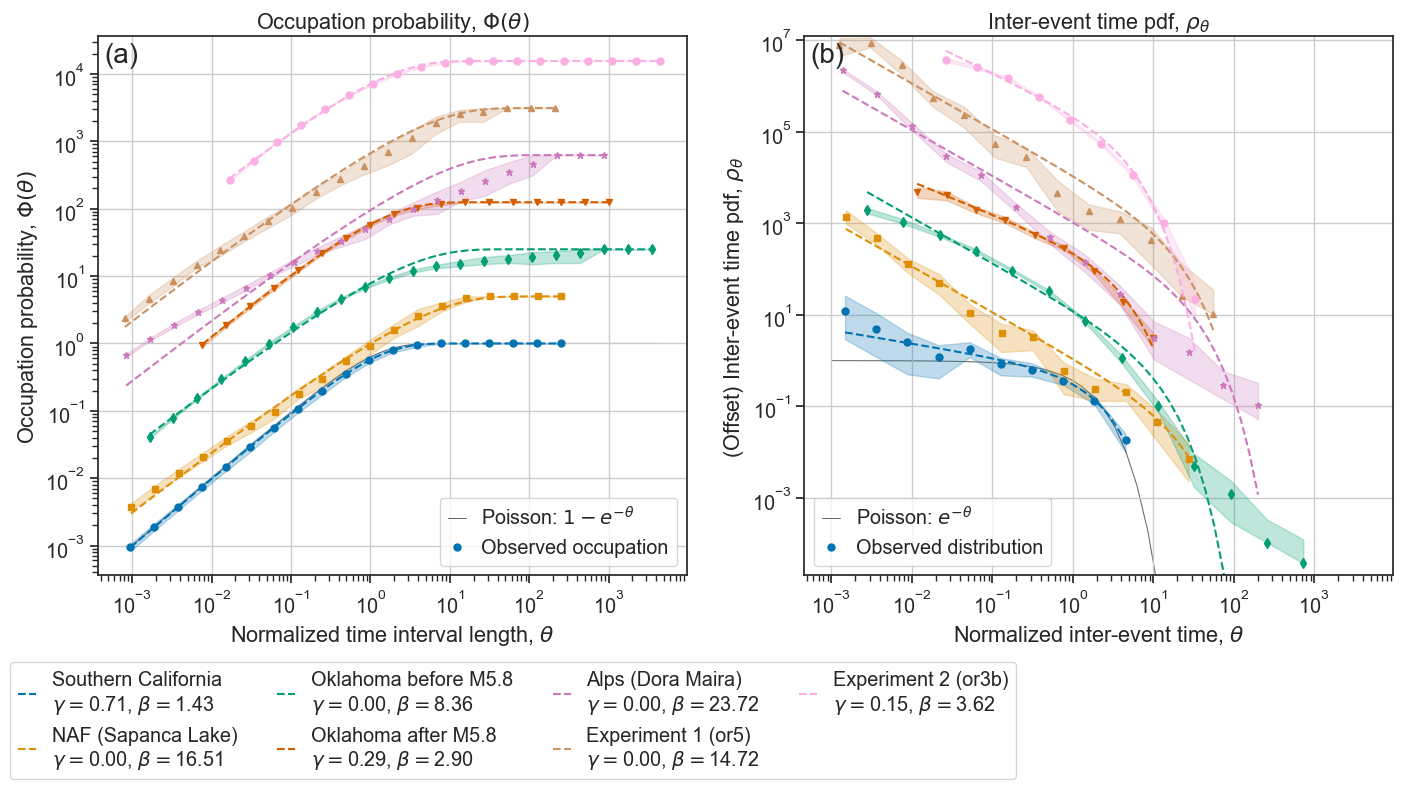

In [14]:
markers = ["o", "s", "d", "v", "*", "^"]
base_offset_occ = 5.0

fig, axes = plt.subplots(num="all_results_gamma", ncols=2, figsize=(14, 7))
plt.subplots_adjust(left=0.07, right=0.995)

time_max = max([occupation[ds]["tau"].max()] for ds in dataset_names)
wt_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
tau_fit = np.logspace(np.log10(NORMALIZED_TAU_MIN), np.log10(time_max), 50)
axes[0].plot(
    tau_fit,
    1.0 - np.exp(-tau_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $1 - e^{-\theta}$",
)
axes[1].plot(
    wt_fit,
    np.exp(-wt_fit),
    color="dimgrey",
    lw=0.75,
    zorder=0.0,
    label=r"Poisson: $e^{-\theta}$",
)

fit_labels = []
fit_plots = []

for i, name in enumerate(plotting_order):
    wt_pdf = occupation[name]["wt_pdf"]
    wt_pdf_lower = occupation[name]["wt_pdf_lower"]
    wt_pdf_upper = occupation[name]["wt_pdf_upper"]
    wt_bins = occupation[name]["wt_bins"]
    tau = occupation[name]["tau"]
    Phi = occupation[name]["Phi"]
    Phi_lower = occupation[name]["Phi_lower"]
    Phi_upper = occupation[name]["Phi_upper"]

    valid_bins = wt_pdf > 0.0

    wt_fit = np.logspace(
        np.log10(wt_bins[valid_bins].min()), np.log10(wt_bins[valid_bins].max()), 50
    )
    tau_fit = np.logspace(np.log10(tau.min()), np.log10(tau.max()), 50)

    # correction factor for the gamma distribution, taking into account that
    # the empirical distribution is normalized over a finite range of waiting times
    truncated_C = eqtempclust.truncated_norm_gamma(
        occupation[name]["gamma"],
        occupation[name]["beta"],
        wt_bins.min(),
        wt_bins.max(),
    )
    theoretical_C = eqtempclust.theoretical_norm_gamma(
        occupation[name]["gamma"], occupation[name]["beta"]
    )
    ratio_C = theoretical_C / truncated_C

    label = "Observed distribution" if i == 0 else ""
    (wtplot,) = axes[1].plot(
        wt_bins[valid_bins],
        10.0**i * wt_pdf[valid_bins],
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[1].fill_between(
        wt_bins[valid_bins],
        10.0**i * wt_pdf_lower[valid_bins],
        10.0**i * wt_pdf_upper[valid_bins],
        color=wtplot.get_color(),
        alpha=0.25,
    )

    label = "Observed occupation" if i == 0 else ""
    (occ,) = axes[0].plot(
        tau,
        base_offset_occ**i * Phi,
        ls="",
        markersize=5,
        marker=markers[i % len(markers)],
        label=label,
    )
    axes[0].fill_between(
        tau,
        base_offset_occ**i * Phi_lower,
        base_offset_occ**i * Phi_upper,
        color=occ.get_color(),
        alpha=0.25,
    )

    wt_gamma_model = eqtempclust.gamma_waiting_times(
        wt_fit, occupation[name]["gamma"], beta=occupation[name]["beta"], normalized=False
    )
    occupation_gamma_model = eqtempclust.occupation_probability_gamma_model(
        tau_fit, occupation[name]["gamma"], beta=occupation[name]["beta"]
    )

    label = f"{beautiful_names[name]}\n" r"$\gamma=$" f"{occupation[name]['gamma']:.2f}" r", $\beta=$"f"{occupation[name]['beta']:.2f}"
    (line,) = axes[0].plot(
        tau_fit,
        base_offset_occ**i * occupation_gamma_model,
        ls="--",
        color=occ.get_color(),
    )
    axes[1].plot(
        wt_fit, 10.0**i * wt_gamma_model / ratio_C, ls="--", color=occ.get_color()
    )
    fit_labels.append(label)
    fit_plots.append(line)

axes[0].set_title(r"Occupation probability, $\Phi(\theta)$")
axes[0].set_ylabel(r"Occupation probability, $\Phi(\theta)$")
axes[0].set_xlabel(r"Normalized time interval length, $\theta$")

axes[1].set_title(r"Inter-event time pdf, $\rho_{\theta}$")
axes[1].set_ylabel(r"(Offset) Inter-event time pdf, $\rho_{\theta}$")
axes[1].set_xlabel(r"Normalized inter-event time, $\theta$")

axes[1].legend(loc="lower left", handlelength=0.9)
axes[0].legend(loc="lower right", handlelength=0.9)
fig.legend(
    fit_plots,
    fit_labels,
    handlelength=0.9,
    ncol=4,
    bbox_to_anchor=(0.0, 0.0),
    loc="upper left",
)

axes[1].set_ylim(0.9 * wt_pdf[valid_bins].min(), axes[1].get_ylim()[1])

for i, ax in enumerate(axes):
    ax.grid()
    ax.loglog()
    ax.text(
        0.01,
        0.99,
        f"({string.ascii_lowercase[i]})",
        va="top",
        ha="left",
        fontsize=20,
        transform=ax.transAxes,
    )

In [15]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

### part 3 (AIC)

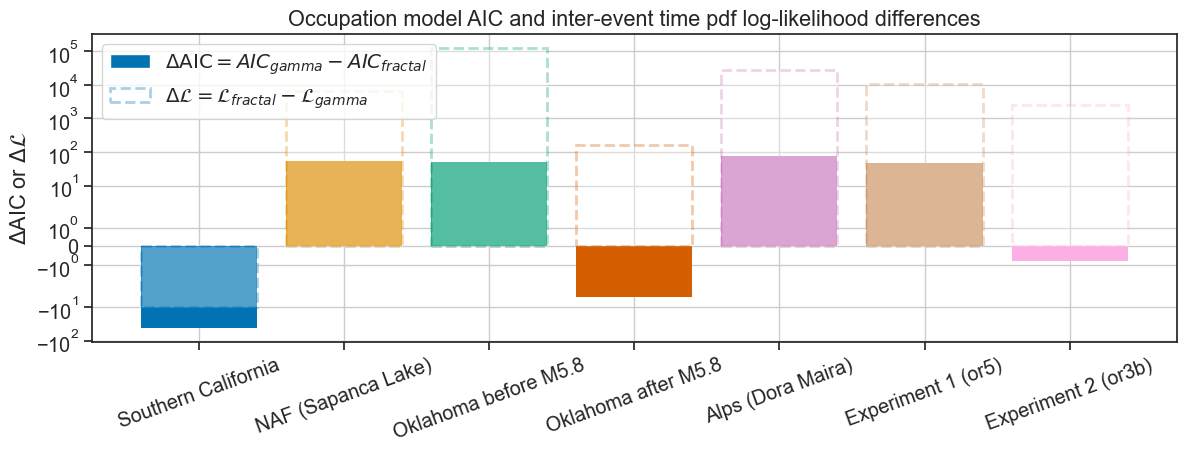

In [95]:
plotting_order = [
    "socal", "naf", "pawnee_before", "pawnee_after", "dora_maira", "or5", "or3b", 
]

fig, ax = plt.subplots(num="aic_difference", figsize=(14, 4))
# axb = ax.twinx()
for i, name in enumerate(plotting_order):
    aic_gamma = occupation[name]["aic_gamma"]
    loglikelihood_gamma = occupation[name]["loglikelihood_wt_gamma"]
    aic_fractal = occupation[name]["aic_fractal"]
    loglikelihood_fractal = occupation[name]["loglikelihood_wt_fractal"]
    # probability that fractal model minimizes the information loss instead of the gamma model
    aic_diff = aic_gamma - aic_fractal
    ll_diff = loglikelihood_fractal - loglikelihood_gamma
    if i == 0:
        label_aic = r"$\Delta \mathrm{AIC} = AIC_{gamma} - AIC_{fractal}$"
        label_ll = r"$\Delta \mathcal{L} = \mathcal{L}_{fractal} - \mathcal{L}_{gamma}$"
    else:
        label_aic = None
        label_ll = None
    bar_ = ax.bar(i, aic_diff, ls="", alpha=1, label=label_aic)
    ax.bar(i, ll_diff, ls="--", lw=2, alpha=0.33, edgecolor=f"C{i}", facecolor="w", label=label_ll)
ax.set_yscale("symlog")
ax.set_xticks(0.0 + np.arange(len(plotting_order)))
ax.set_xticklabels(
    [beautiful_names[name] for name in plotting_order],
    rotation=20,
    ha="center",
    va="top",
)
ax.grid()
ax.set_ylabel(r"$\Delta$AIC or $\Delta \mathcal{L}$")
ax.set_title((r"Occupation model AIC and inter-event time pdf log-likelihood differences"))

ax.legend(loc="upper left")

In [96]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg"
# )

## Figure 3: Compare with forward model

/var/folders/dv/ly3mdyfn2rg8_nbsghjxvhjh0000gn/T/ipykernel_76343/3549949582.py:155: RuntimeWarning: invalid value encountered in divide
  syn_gamma_iet_i / syn_gamma_iet_i.mean(), bins=theta_, return_midbins=True
/Users/eric/Documents/WORK/software/eqtempclust/eqtempclust.py:1038: RuntimeWarning: invalid value encountered in divide
  ie_pdf = ie_times_count / (bin_sizes * ie_times_count.sum())
/Users/eric/Documents/WORK/software/eqtempclust/eqtempclust.py:1050: RuntimeWarning: invalid value encountered in divide
  ie_pdf_b[i, :] = ie_times_count_b / (bin_sizes * ie_times_count_b.sum())


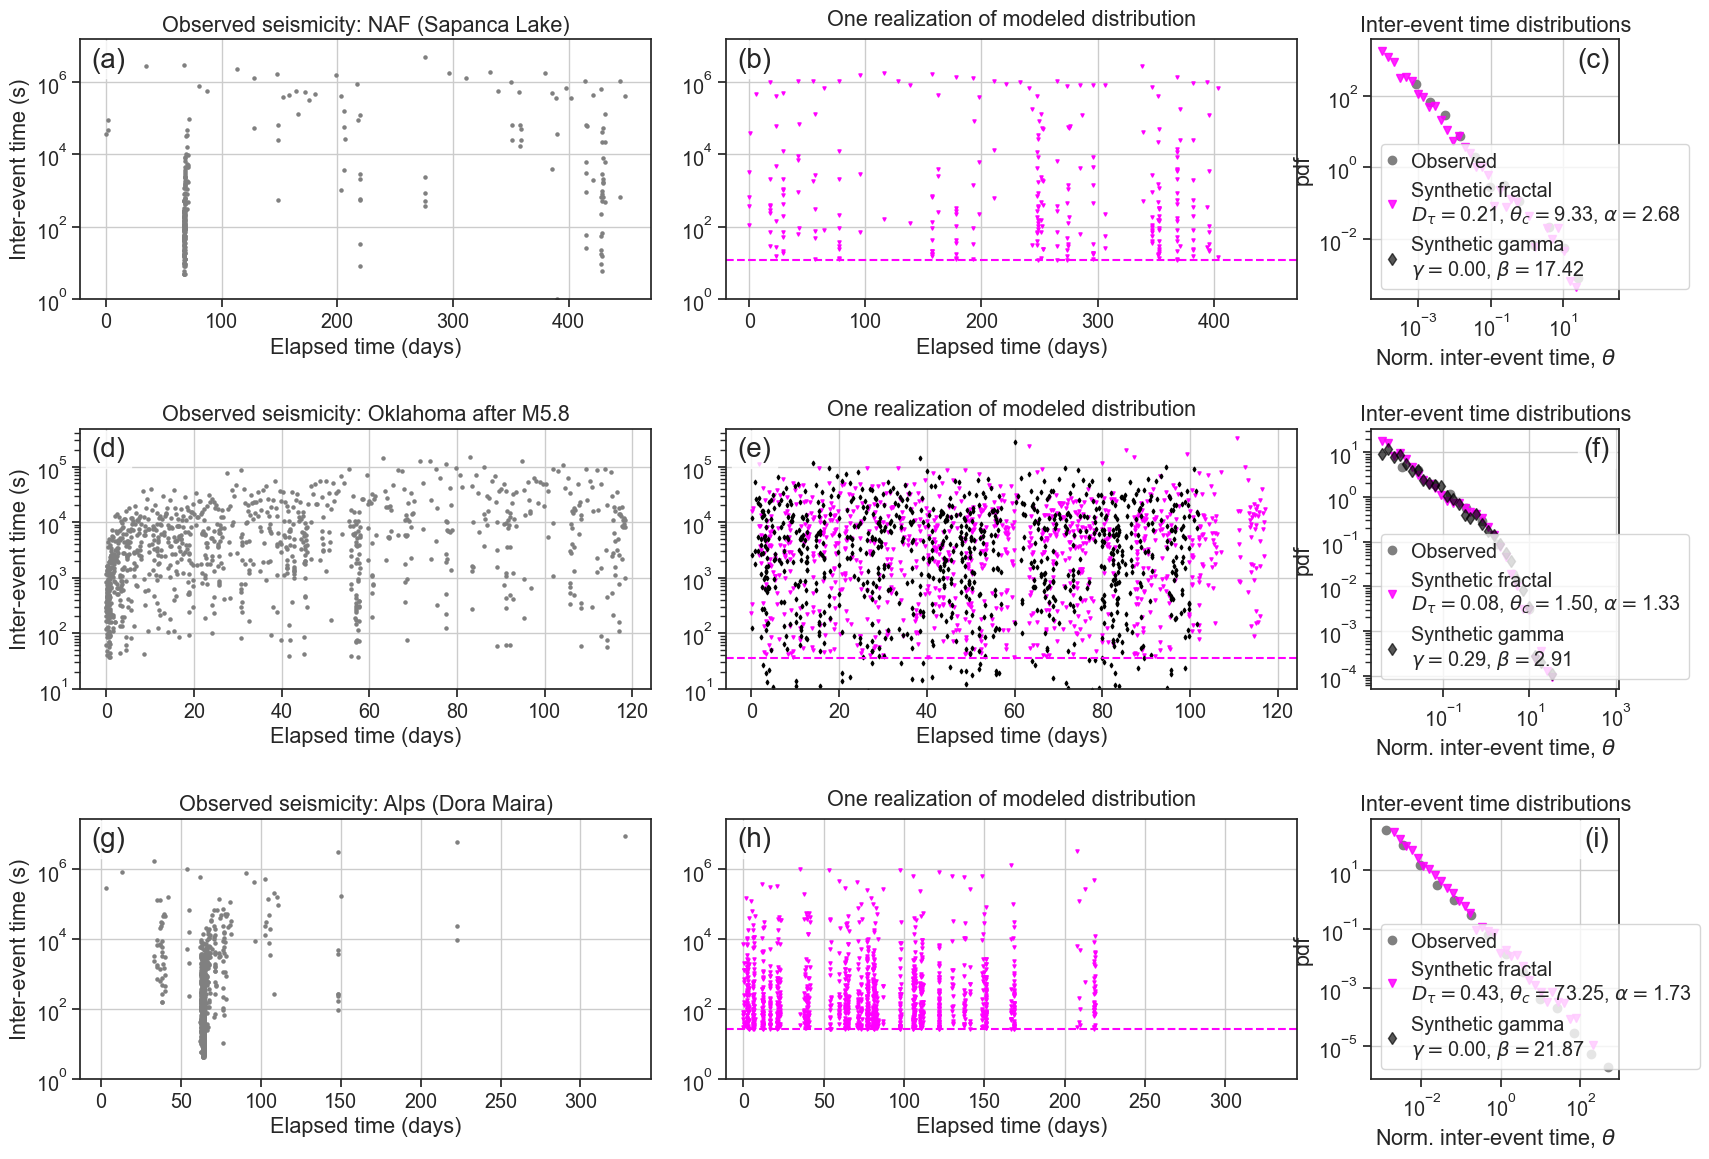

In [18]:
dataset_names = [
    "naf",
    "pawnee_after",
    "dora_maira",
]
COLOR_OBSERVED = "grey"
COLOR_GAMMA = "black"
COLOR_FRACTAL = "magenta"

ALPHA_GAMMA = 0.66
ALPHA_FRACTAL = 0.85
GAMMA_MIN = 0.
num_catalogs = len(dataset_names)

fig = plt.figure("compare_with_forward_model_v3", figsize=(18, 4.5 * num_catalogs))
gs = fig.add_gridspec(ncols=5, nrows=num_catalogs, wspace=0.3, hspace=0.5)

axes_iet_data = []
axes_iet_syn = []
axes_pdf = []

for i, catname in enumerate(dataset_names):
    # -------------------------------------------------
    interevent_times = np.hstack(
        (np.nan, event_timings[catname][1:] - event_timings[catname][:-1])
    )
    event_timings_days = event_timings[catname] / 86400.0
    event_timings_days -= event_timings_days[0]
    ax_iet_data = fig.add_subplot(gs[i, :2])
    ax_iet_data.scatter(
        event_timings_days,
        interevent_times,
        s=5,
        color=COLOR_OBSERVED,
        label="Observed",
        rasterized=True,
    )
    ax_iet_data.set_title(f"Observed seismicity: {beautiful_names[catname]}")
    axes_iet_data.append(ax_iet_data)
    # -------------------------------------------------
    ax_iet_syn = fig.add_subplot(gs[i, 2:4], sharey=ax_iet_data)
    D_tau_i = occupation[catname]["D_tau"]
    alpha_i = occupation[catname]["alpha"]
    theta_c_i = occupation[catname]["tau_c"]

    normalized_theta_min = eqtempclust.tau_min_fractal(
        1.0 - D_tau_i, theta_c_i, alpha_i
    )
    normalized_theta_max = occupation[catname]["wt_bins"].max()

    theta_ = np.logspace(
        np.log10(normalized_theta_min), np.log10(normalized_theta_max), 40
    )
    cdf_fractal_i = eqtempclust.cdf_fractal(theta_, 1.0 - D_tau_i, theta_c_i, alpha_i)
    inverse_cdf_fractal_i = interp1d(cdf_fractal_i, theta_)

    syn_fractal_iet_i = (
        inverse_cdf_fractal_i(
            np.random.uniform(
                low=cdf_fractal_i.min(),
                high=cdf_fractal_i.max(),
                size=len(event_timings_days),
            )
        )
        * occupation[catname]["wt_mean"]
    )

    syn_fractal_timings_i = np.cumsum(syn_fractal_iet_i)
    label_fractal = (
        f"Synthetic fractal\n"
        r"$D_\tau=$"
        f"{D_tau_i:.2f}, "
        r"$\theta_c=$"
        f"{theta_c_i:.2f}, "
        r"$\alpha=$"
        f"{alpha_i:.2f}"
    )
    ax_iet_syn.scatter(
        syn_fractal_timings_i / 86400.0,
        syn_fractal_iet_i,
        s=5,
        marker="v",
        label=label_fractal,
        color=COLOR_FRACTAL,
        rasterized=True,
    )
    ax_iet_syn.axhline(
        eqtempclust.tau_min_fractal(1.0 - D_tau_i, theta_c_i, alpha_i)
        * occupation[catname]["wt_mean"],
        color=COLOR_FRACTAL,
        ls="--",
    )

    gamma_i = occupation[catname]["gamma"]
    beta_i = occupation[catname]["beta"]

    cdf_gamma_i_min = eqtempclust.cdf_gamma(theta_.min(), gamma_i, beta_i)


    syn_gamma_iet_i = (
        eqtempclust.inverse_cdf_gamma(
            np.random.random(size=len(event_timings_days)),
            max(GAMMA_MIN, gamma_i),
            beta_i,

        )
        * occupation[catname]["wt_mean"]
    )

    syn_gamma_timings_i = np.cumsum(syn_gamma_iet_i)
    label_gamma = (
        f"Synthetic gamma\n" r"$\gamma=$" f"{gamma_i:.2f}, " r"$\beta=$" f"{beta_i:.2f}"
    )
    if gamma_i > GAMMA_MIN:
        ax_iet_syn.scatter(
            syn_gamma_timings_i / 86400.0,
            syn_gamma_iet_i,
            s=5,
            marker="d",
            label=label_gamma,
            color=COLOR_GAMMA, alpha=1,
            rasterized=True,
        )

    ax_iet_syn.set_title(
        rf"One realization of modeled distribution",
        pad=10,
    )
    # ax_iet_i.set_ylim(theta_.min() * occupation[catname]["wt_mean"], theta_.max() * occupation[catname]["wt_mean"])
    ylim_min = 10.**np.floor(np.log10(np.percentile(interevent_times[~np.isnan(interevent_times)], 1)))
    ylim_max = 10.**(np.log10(np.nanmax(interevent_times)) + 0.5)
    # ax_iet_syn.set_ylim(ylim_min, ylim_max)
    ax_iet_data.set_ylim(ylim_min, ylim_max)
    axes_iet_syn.append(ax_iet_syn)
    # -------------------------------------------------
    ax_pdf_i = fig.add_subplot(gs[i, 4])
    ax_pdf_i.plot(
        occupation[catname]["wt_bins"],
        occupation[catname]["wt_pdf"],
        ls="",
        marker="o",
        color=COLOR_OBSERVED,
        label="Observed",
    )
    axes_pdf.append(ax_pdf_i)
    # -------------------------------------------------
    wt_pdf, wt_pdf_lower, wt_pdf_upper, wt_log_bins = eqtempclust.interevent_pdf(
        syn_fractal_iet_i / syn_fractal_iet_i.mean(), bins=theta_, return_midbins=True
    )
    ax_pdf_i.plot(
        wt_log_bins, wt_pdf, ls="", marker="v", color=COLOR_FRACTAL, alpha=ALPHA_FRACTAL, label=label_fractal
    )
    # -------------------------------------------------
    wt_pdf, wt_pdf_lower, wt_pdf_upper, wt_log_bins = eqtempclust.interevent_pdf(
        syn_gamma_iet_i / syn_gamma_iet_i.mean(), bins=theta_, return_midbins=True
    )
    if gamma_i > GAMMA_MIN:
        ax_pdf_i.plot(wt_log_bins, wt_pdf, ls="", marker="d", color=COLOR_GAMMA, alpha=ALPHA_GAMMA, label=label_gamma)
    ax_pdf_i.set_title("Inter-event time distributions")

for i, (ax1, ax2, ax3) in enumerate(zip(axes_iet_data, axes_iet_syn, axes_pdf)):
    ax1.grid()
    ax1.set_yscale("log")
    ax1.set_xlabel("Elapsed time (days)")
    ax1.set_ylabel("Inter-event time (s)")
    # ax1.legend(loc="upper right", handlelength=0.3)

    ax2.grid()
    ax2.set_yscale("log")
    ax2.set_xlabel("Elapsed time (days)")
    # ax2.legend(loc="upper right", handlelength=0.3)
    ax2.set_xlim(ax2.get_xlim()[0], ax1.get_xlim()[1])

    ax3.grid()
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    ax3.set_xlabel(r"Norm. inter-event time, $\theta$")
    ax3.set_ylabel("pdf")
    ax3.legend(loc="lower left", handlelength=0.3)

    ax1.text(
        0.02,
        0.97,
        f"({string.ascii_lowercase[3*i]})",
        va="top",
        fontsize=20,
        ha="left",
        bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax1.transAxes,
    )
    ax2.text(
        0.02,
        0.97,
        f"({string.ascii_lowercase[3*i+1]})",
        va="top",
        fontsize=20,
        ha="left",
        bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax2.transAxes,
    )
    ax3.text(
        0.96,
        0.97,
        f"({string.ascii_lowercase[3*i+2]})",
        va="top",
        fontsize=20,
        ha="right",
        bbox={"facecolor": "white", "alpha": 0.75},
        transform=ax3.transAxes,
    )

plt.subplots_adjust(right=0.98, wspace=0.5)

In [19]:
# fig.savefig(
#     fig.get_label() + ".svg", bbox_inches="tight", format="svg", dpi=250
# )

In [20]:
results = {
    "name": [],
    "D_tau": [],
    "D_tau_err": [],
    "alpha": [],
    "alpha_err": [],
    "tau_c": [],
    "tau_c_err": [],
}

for name in occupation:
    results["name"].append(beautiful_names[name])
    results["D_tau"].append(1.0 - occupation[name]["n"])
    results["D_tau_err"].append(occupation[name]["n_err"])
    results["alpha"].append(occupation[name]["alpha"])
    results["alpha_err"].append(occupation[name]["alpha_err"])
    results["tau_c"].append(occupation[name]["tau_c"])
    results["tau_c_err"].append(occupation[name]["tau_c_err"])
results = pd.DataFrame(results)
results.set_index("name", inplace=True)
results

,D_tau,D_tau_err,alpha,alpha_err,tau_c,tau_c_err
name,,,,,,
NAF (Sapanca Lake),2.131890e-01,0.003318,2.677479,0.231901,9.331051,0.230770
Alps (Dora Maira),4.283563e-01,0.010889,1.733172,0.289902,73.248088,10.288323
Experiment 2 (or3b),9.585048e-02,0.021539,1.201181,0.095634,1.471885,0.131644
Experiment 1 (or5),2.842972e-01,0.007522,2.580415,0.447351,11.491560,0.705566
Southern California,3.481244e-02,0.004997,1.650682,0.072636,1.214413,0.028445
Oklahoma before M5.8,1.110223e-16,0.035528,0.521345,0.042479,0.868811,0.186977
Oklahoma after M5.8,8.119511e-02,0.009328,1.330102,0.062244,1.503650,0.062216
